# RL and Advanced DL: Домашнее задание 1

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.


### Общий код
Здесь сохраним общую часть кода, которая используется разных частях задачи

In [72]:
%pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 kB 2.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 kB 4.4 MB/s eta 0:00:0000:01
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached PyYAML-6.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (682 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 16.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.8 MB/s eta 0:00:00
  Using cached zipp-3.9.0-py3-none-any.whl (5.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 kB 16.6 MB/s eta 0:00:00


In [74]:
import gym
import sys
import optuna
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
from collections import defaultdict

import random

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

ACTION_NAMES = ["stand", "hit"]
DEBUG = False

/home/fatuus/venv_adl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
# https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
env = gym.make('Blackjack-v1') 
env.reset()

((16, 8, False), {})

In [31]:
def sum_hand(hand):
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def usable_ace(hand):
    return 1 in hand and sum(hand) + 10 <= 21


def get_obs(env):
    return (
        sum_hand(env.player),
        env.dealer[0],
        usable_ace(env.player)
    )


def play(env, strategy, verbose=False, seed=None, **kwargs):
    if seed is not None:
        env.seed(seed)
        env.action_space.seed(seed)
    states, actions, rewards = [], [], []
    initial = env.reset()
    if verbose:
        print(f"init: {initial}")
    done = False
    while not done:
        states.append(get_obs(env))
        action = strategy(env=env, **kwargs)
        actions.append(action)
        if verbose:
            print(
                f"before step: action={ACTION_NAMES[action]} "
                f"obs={get_obs(env)}"
            )
        state_new, reward, done, info, _ = env.step(action)
        rewards.append(reward)
        if verbose: 
            print(
                f"after step: state_new={state_new}, "
                f"reward={reward}, done={done}, info={info}"
            )
    else:
        if verbose:
            if reward > 0:
                print("Game result: win.")
            elif reward < 0:
                print("Game result: loss.")
            else:
                print("Game result: draw.")
    env.close()
    return states, actions, rewards

# def play(strategy, env, verbose=True):
#   """
  
#   """
#   history = list()
#   done = False
#   init = env.reset()
#   states, actions, rewards = [], [], []
#   if verbose:
#     print(f"Начальная раздача: {init}")
#   while not done:
#     state = get_obs(env)
#     action_code, action_name = strategy(env)
#     state_prime, reward, done, info, _ = env.step(action=action_code)
#     states.append(state)
#     actions.append(action_name)
#     rewards.append(reward)
#     if verbose:
#       print(
#           f"s[t]={state} a[t]={action_name}, r[t]={reward}, "
#           f"s[t+1]={state_prime} done={done}"
#       )
#   if verbose:
#     if reward > 0:
#       print("Победа.")
#     elif reward < 0:
#       print("Поражение.")
#     else:
#       print("Ничья.")
#   return states, actions, rewards


## 1. Часть первая, с блекджеком и стратегиями
Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек.

Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
 -  численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
 - туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
 - игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
 - игрок может совершать одно из двух действий:
   - hit — взять ещё одну карту;
   - stand — не брать больше карт;
   
 - если сумма очков у игрока на руках больше 21, он проигрывает (bust);
 - если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
 - после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
 - в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).


Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.
3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

### 1.1 Рандомная стратегия
Попробуем принимать решения случайно и посмотрим что получится

In [39]:
# Сначала прпробуем случайную стратегию

# def random_strategy(env):
#   code = random.randint(0, 1)
#   return code

# play(strategy=random_strategy, env=env)


def random_strategy(env):
  return env.action_space.sample()

play(
    env=gym.make('Blackjack-v1', natural=True),
    strategy=random_strategy, 
    verbose=True
)


init: ((6, 6, False), {})
before step: action=stand obs=(6, 6, False)
after step: state_new=(6, 6, False), reward=1.0, done=True, info=False
Game result: win.


([(6, 6, False)], [0], [1.0])

### 1.2. Оценка простой стратегии методом Monte Carlo Estimation
Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Воспользуемся методом Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [41]:
def simple_strategy(env):
    return int(sum_hand(env.player) < 19)

play(
    env=gym.make('Blackjack-v1', natural=True),
    strategy=simple_strategy,
    verbose=True
)

init: ((17, 9, False), {})
before step: action=hit obs=(17, 9, False)
after step: state_new=(20, 9, False), reward=0.0, done=False, info=False
before step: action=stand obs=(20, 9, False)
after step: state_new=(20, 9, False), reward=1.0, done=True, info=False
Game result: win.


([(17, 9, False), (20, 9, False)], [1, 0], [0.0, 1.0])

In [51]:
%%time

def mc_prediction(
    strategy, 
    env, 
    n_episodes=10_000, 
    gamma=0.8, 
    alpha=None, 
    seed=None,
    verbose=False,
    every_visit=False
):
    verbose_step = n_episodes // 10 or 1
    counts = defaultdict(int)
    values = defaultdict(float)

    #env.seed(seed)
    #env.action_space.seed(seed)
    
    env.reset(seed=seed)
    
    for episode_idx in range(n_episodes):
        states, actions, rewards = play(env=env, strategy=strategy)
        g = 0.0
        for t in range(len(states) - 1, -1, -1):
            reward = rewards[t]
            state = states[t]
            g = reward + gamma * g
            if every_visit or state not in states[:t]:
                counts[state] += 1
                if alpha is None:
                    values[state] += (g - values[state]) / counts[state]
                else:
                    values[state] += (g - values[state]) * alpha
        if verbose and (episode_idx % verbose_step == 0):
            print(f"{episode_idx+1} episodes of {n_episodes} passed")
            sys.stdout.flush()
    return values


values = mc_prediction(
    strategy=simple_strategy,
    env=gym.make('Blackjack-v1', natural=True),
    n_episodes= 100 if DEBUG else 100000
)

print(f"values={values}")
print(f"mean value: {np.mean(list(values.values()))}")


values=defaultdict(<class 'float'>, {(20, 10, False): 1.0, (10, 10, False): 0.07999999999999996, (21, 10, True): 0.6666666666666666, (12, 10, False): -0.172, (11, 10, False): -0.8, (21, 2, False): 1.0, (16, 2, False): -0.39999999999999997, (15, 2, False): 0.6400000000000001, (15, 2, True): 0.5120000000000001, (18, 10, False): -0.64, (15, 5, False): -0.8666666666666667, (11, 5, False): -0.8, (17, 10, False): -0.9, (16, 6, False): -1.0, (19, 1, False): -0.25, (17, 7, False): -1.0, (21, 8, False): 1.0, (14, 8, False): -0.26666666666666666, (6, 8, False): 0.6400000000000001, (20, 9, False): 1.0, (17, 9, False): -0.09999999999999998, (6, 6, False): -0.8, (19, 6, False): -1.0, (17, 6, False): -0.9, (17, 6, True): -0.6400000000000001, (18, 8, False): -0.39999999999999997, (11, 8, False): -0.7200000000000001, (7, 8, False): -0.5120000000000001, (13, 3, False): -0.9333333333333333, (16, 5, False): -1.0, (19, 4, False): 1.0, (9, 4, False): 0.8, (21, 3, False): 0.75, (18, 3, False): -0.4, (11, 3,

In [55]:
%%time

def mean_reward(
    strategy, 
    env, 
    n_episodes=10_000, 
    verbose=True, 
    play=play, 
    **kwargs
):
    reward_sum = 0
    verbose_step = n_episodes // 10 or 1
    for episode_idx in range(n_episodes):
        states, actions, rewards = play(
            strategy=strategy, env=env, verbose=False, **kwargs
        )
        reward_sum += rewards[-1]
        if verbose and (episode_idx % verbose_step == 0):
            print(f"{episode_idx+1} episodes of {n_episodes} passed")
            sys.stdout.flush()
    return reward_sum / n_episodes


print(
    mean_reward(
        env=gym.make('Blackjack-v1', natural=True),
        strategy=random_strategy, 
        n_episodes=100 if DEBUG else 100000
    )
)


1 episodes of 100 passed
11 episodes of 100 passed
21 episodes of 100 passed
31 episodes of 100 passed
41 episodes of 100 passed
51 episodes of 100 passed
61 episodes of 100 passed
71 episodes of 100 passed
81 episodes of 100 passed
91 episodes of 100 passed
-0.44
CPU times: user 37.5 ms, sys: 0 ns, total: 37.5 ms
Wall time: 29 ms


In [57]:
%%time
print(
    mean_reward(
        env=gym.make('Blackjack-v1', natural=True),
        strategy=simple_strategy, 
        n_episodes=100 if DEBUG else 100000
    )
)


1 episodes of 100 passed
11 episodes of 100 passed
21 episodes of 100 passed
31 episodes of 100 passed
41 episodes of 100 passed
51 episodes of 100 passed
61 episodes of 100 passed
71 episodes of 100 passed
81 episodes of 100 passed
91 episodes of 100 passed
-0.28
CPU times: user 34.7 ms, sys: 0 ns, total: 34.7 ms
Wall time: 29.9 ms


### 1.3 Обучение: monte carlo control
Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.


In [68]:
%%time

def eps_greedy_strategy(env, eps, q_table):
    state = get_obs(env)
    if random.random() > eps:
        return q_table[state].argmax()
    else:
        return env.action_space.sample()


def epsilon_generator(start=1.0, min_value=0.01, decay=0.99999):
    eps = start
    command = None
    while True:
        if command == "restart":
            eps = start
        if eps > min_value:
            yield eps
            eps = eps * decay 
        else:
            yield min_value


def mc_control(
    env,
    eps_gen=itertools.repeat(0.01),
    n_episodes=100_000,
    gamma=0.15,
    verbose=True,
    play=play
):
    q = defaultdict(lambda: np.zeros(env.action_space.n))
    counts = defaultdict(int)
    verbose_step = (n_episodes // 10) or 1
    for episode_idx in range(n_episodes):
        epsilon = next(eps_gen)
        states, actions, rewards = play(
            strategy=eps_greedy_strategy, env=env, q_table=q, eps=epsilon
        )
        states_actions = list(zip(states, actions))
        g = 0
        for t in range(len(states) - 1, -1, -1):
            state = states[t]
            action = actions[t]
            reward = rewards[t]
            g = gamma * g + reward
            if (state, action) not in states_actions[:t]:
                counts[(state, action)] += 1
                q[state][action] += (
                    (g - q[state][action]) / counts[(state, action)]
                )
        if verbose and (episode_idx % verbose_step == 0):
            print(f"{episode_idx}/{n_episodes}: eps={epsilon}.")
            sys.stdout.flush()
    strategy_best = lambda env, q_table: eps_greedy_strategy(
        env=env, eps=0, q_table=q_table
    )
    return strategy_best, q


n_episodes = 100 if DEBUG else 1000000
strategy_best, q_best = mc_control(
    env=gym.make('Blackjack-v1', natural=True),
    n_episodes=n_episodes,
    eps_gen=epsilon_generator(
        start=1.0, min_value=0.01, decay=0.01**(1/n_episodes)
    )
)
print(
    mean_reward(
        env=gym.make('Blackjack-v1', natural=True),
        strategy=strategy_best, 
        n_episodes=n_episodes, 
        q_table=q_best, 
        verbose=False
    )
)


0/1000000: eps=1.0.
100000/1000000: eps=0.6309573444789967.
200000/1000000: eps=0.39810717055198175.
300000/1000000: eps=0.2511886431495252.
400000/1000000: eps=0.15848931924490736.
500000/1000000: eps=0.09999999999904918.
600000/1000000: eps=0.0630957344472981.
700000/1000000: eps=0.039810717054818985.
800000/1000000: eps=0.025118864314712903.
900000/1000000: eps=0.015848931924339192.
-0.046656
CPU times: user 4min 21s, sys: 45.2 ms, total: 4min 21s
Wall time: 4min 21s


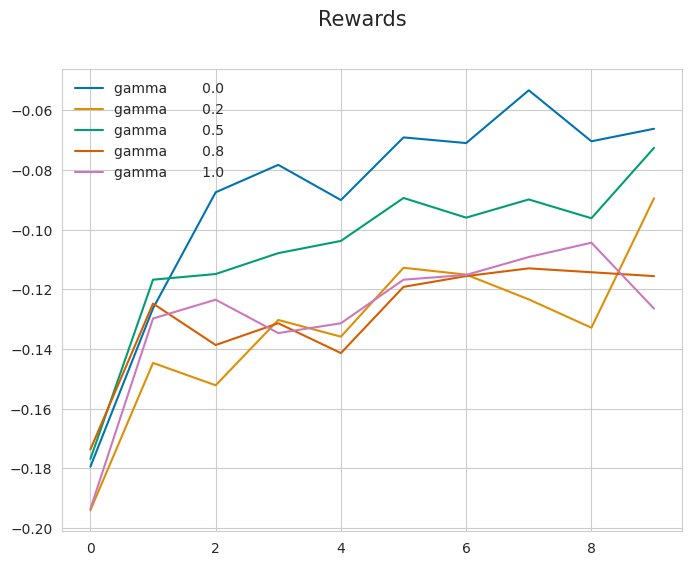

CPU times: user 1min 7s, sys: 290 ms, total: 1min 7s
Wall time: 1min 7s


In [67]:
%%time

def mc_control_history(
    env,
    n_episodes=10_000,
    n_episodes_test=10_000,
    gamma_start=0.0,
    gamma_finish=1.0,
    eps_gen=itertools.repeat(0.01),
    verbose=True
):    
    rewards_total = list()
    gammas = np.linspace(gamma_start, gamma_finish, num=5)
    is_first_iter = True
    step = (n_episodes // 10) or 1
    for gamma in gammas:
        if not is_first_iter:
            eps_gen.send("restart")
        else:
            is_first_iter = False
        q = defaultdict(lambda: np.zeros(env.action_space.n))
        counts = defaultdict(int)
        rewards_gamma = list()
        for episode_idx in range(n_episodes):
            epsilon = next(eps_gen)
            if episode_idx % step == 0:
                strategy_best = lambda env, q_table: eps_greedy_strategy(
                    env=env, eps=0, q_table=q_table
                )
                rewards_gamma.append(
                    mean_reward(
                        strategy=strategy_best, 
                        env=env, 
                        n_episodes=n_episodes_test, 
                        q_table=q,
                        verbose=False
                    )
                )
                if verbose:
                    print(
                        f"{episode_idx}/{n_episodes}: "
                        f"reward={rewards_gamma[-1]} "
                        f"gamma={gamma}"
                    )
                    sys.stdout.flush()
            states, actions, rewards = play(
                env=env, strategy=eps_greedy_strategy, q_table=q, eps=epsilon
            )
            states_actions = list(zip(states, actions))
            g = 0
            for t in range(len(states) - 1, -1, -1):
                state, action, reward  = states[t], actions[t], rewards[t]
                g = reward + gamma * g
                if (state, action) not in states_actions[:t]:
                    counts[(state, action)] += 1
                    q[state][action] += (
                        (g - q[state][action]) / counts[(state, action)]
                    )
        rewards_total.append(list(rewards_gamma))
    return rewards_total


gamma_start = 0.0
gamma_finish = 1.0
n_episodes = 100 if DEBUG else 10_000
rewards = mc_control_history(
    env=gym.make('Blackjack-v1', natural=True),
    n_episodes=n_episodes, 
    n_episodes_test=n_episodes, 
    gamma_start=gamma_start, 
    gamma_finish=gamma_finish, 
    eps_gen=epsilon_generator(
        start=1.0, min_value=0.01, decay=0.01**(1/n_episodes)
    ),
    verbose=False
)

fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Rewards', fontsize=15)
for i in range(len(rewards)):
    gamma = gamma_start + i * (gamma_finish - gamma_start) / 4
    ax.plot(
        rewards[i],
        label=f"gamma {gamma:10.1f}"
    )
plt.legend(frameon=False)
plt.show()


## 1.4 Обучение: q-learning (для себя, если успею)
...

### 1.5 Оценка оптимальной стратегии

Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [78]:

def objective(trial, game='Blackjack-v1', n_episodes=100):
    gamma = trial.suggest_float("gamma", 0, 1)
    eps_start = trial.suggest_float("eps_start", 0, 1)
    eps_fin = eps_start * 0.001
    strategy_best, q_best = mc_control(
        env=gym.make(game, natural=True),
        n_episodes=n_episodes, 
        eps_gen=epsilon_generator(
            start=eps_start,
            min_value=eps_fin,
            decay=0.01**(1/n_episodes)
        ),
        gamma=gamma,
        verbose=False
    )
    reward = mean_reward(
        env=gym.make(game, natural=True),
        strategy=strategy_best,
        n_episodes=n_episodes,
        q_table=q_best, 
        verbose=False
    )
    return -reward


optuna.logging.set_verbosity(optuna.logging.ERROR)
# optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study()
study.optimize(objective, n_trials=100 if DEBUG else 1000)
best_params = dict(**study.best_params, env=env)

strategy_best, q_best = mc_control(
    env=gym.make('Blackjack-v1', natural=True),
    n_episodes=n_episodes, 
    eps_gen=epsilon_generator(
        start=best_params["eps_start"],
        min_value=best_params["eps_start"] * 0.001,
        decay=0.01**(1/n_episodes)
    ),
    verbose=False
)
reward_best = mean_reward(
    env=gym.make('Blackjack-v1', natural=True),
    strategy=strategy_best,
    n_episodes=n_episodes,
    q_table=q_best, 
    verbose=False
)

print(f"best parametes: {best_params}")
print(f"best reward: {reward_best}")


best parametes: {'gamma': 0.2835405954006745, 'eps_start': 0.23203501869395696, 'env': <OrderEnforcing<PassiveEnvChecker<BlackjackEnv<Blackjack-v1>>>>}
best reward: -0.047


## Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:

4. double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

5. Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.

6. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [89]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding
from gym.envs.registration import register, registry
from gym.envs.toy_text.blackjack import *

ACTION_NAMES = [
    "stand", 
    "hit", 
    "double"  # берем карту и удваиваем ставку 
]

class DoublingBlackjackEnv(gym.Env):

    ACTION_STAND = 0
    ACTION_HIT = 1
    ACTION_DOUBLE = 2

    def __init__(self, natural=False):
        self.seed()
        self.natural = natural
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (
                spaces.Discrete(32),
                spaces.Discrete(11),
                spaces.Discrete(2)
            )
        )
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

    def process_stand_action(self):
        done = True
        while sum_hand(self.dealer) < 17:
            self.dealer.append(draw_card(self.np_random))
        reward = cmp(score(self.player), score(self.dealer))
        if self.natural and is_natural(self.player) and reward == 1.:
            reward = 1.5
        return reward, done

    def process_hit_action(self):
        self.player.append(draw_card(self.np_random))
        if is_bust(self.player):
            done = True
            reward = -1.
        else:
            done = False
            reward = 0.
        return reward, done

    def process_double_action(self):
        self.player.append(draw_card(self.np_random))
        done = True
        if is_bust(self.player):
            reward = -2.
        else:
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer)) * 2
        return reward, done

    def step(self, action):
        assert self.action_space.contains(action)
        if action == self.ACTION_STAND:
            reward, done = self.process_stand_action()
        elif action == self.ACTION_HIT:
            reward, done = self.process_hit_action()
        elif action == self.ACTION_DOUBLE:
            reward, done = self.process_double_action()
        return self._get_obs(), reward, done, False, {}


gym.envs.toy_text.blackjack.DoublingBlackjackEnv = DoublingBlackjackEnv
    
if 'Blackjack-v0' in registry:
    del registry['Blackjack-v0']
register(
    id='Blackjack-v0', 
    entry_point='gym.envs.toy_text.blackjack:DoublingBlackjackEnv',
)


In [97]:
play(
    env=gym.make("Blackjack-v0", natural=True), 
    strategy=random_strategy, 
    verbose=True
)

init: (11, 8, False)
before step: action=stand obs=(11, 8, False)
after step: state_new=(11, 8, False), reward=1.0, done=True, info=False
Game result: win.


([(11, 8, False)], [0], [1.0])

In [98]:
%%time
n_episodes = 100 if DEBUG else 1000000
game = 'Blackjack-v1'
study = optuna.create_study()
study.optimize(
    lambda trial: objective(trial=trial, game=game), 
    n_trials=100 if DEBUG else 1000
)
best_params = dict(**study.best_params, env=env)

strategy_best, q_best = mc_control(
    env=gym.make(game, natural=True),
    n_episodes=n_episodes, 
    eps_gen=epsilon_generator(
        start=best_params["eps_start"],
        min_value=best_params["eps_start"] * 0.001,
        decay=0.01**(1/n_episodes)
    ),
    verbose=False
)
reward_best = mean_reward(
    env=gym.make(game, natural=True),
    strategy=strategy_best,
    n_episodes=n_episodes,
    q_table=q_best, 
    verbose=False
)

print(f"best parametes: {best_params}")
print(f"best reward: {reward_best}")



best parametes: {'gamma': 0.9269663799477657, 'eps_start': 0.39470674814733603, 'env': <OrderEnforcing<PassiveEnvChecker<BlackjackEnv<Blackjack-v1>>>>}
best reward: -0.016785
CPU times: user 3min 49s, sys: 332 ms, total: 3min 49s
Wall time: 3min 49s


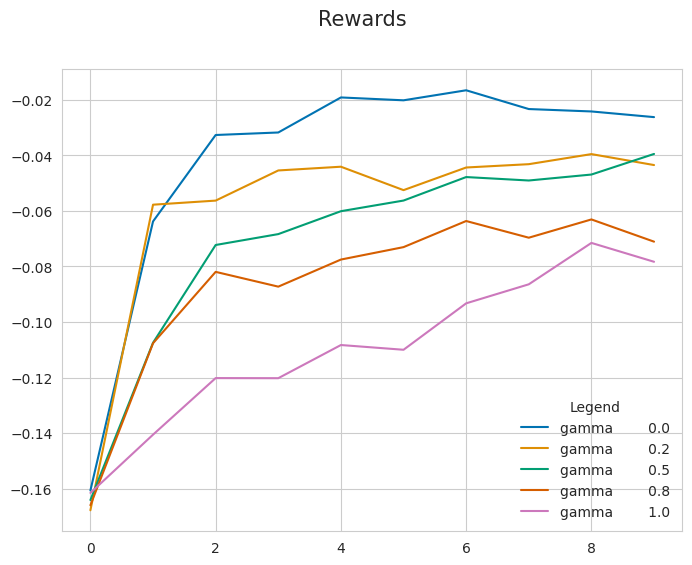

In [99]:
gamma_start = 0.0
gamma_finish = 1.0
n_episodes = 100 if DEBUG else 100_000
rewards = mc_control_history(
    env=gym.make('Blackjack-v1', natural=True), 
    n_episodes=n_episodes, 
    n_episodes_test=n_episodes, 
    gamma_start=gamma_start, 
    gamma_finish=gamma_finish, 
    eps_gen=epsilon_generator(start=1.0, min_value=0.01, decay=0.01**(1/n_episodes)),
    verbose=False
)

fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Rewards', fontsize=15)
for i in range(len(rewards)):
    gamma = gamma_start + i * (gamma_finish - gamma_start) / 4
    ax.plot(
        rewards[i], 
        label=f"gamma {gamma:10.1f}"
    )
plt.legend(loc="lower right", title="Legend", frameon=False)
plt.show()


## Часть третья, в главной роли — Дастин Хоффман
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

6. Реализуйте вариант окружения BlackjackEnv из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет [статья википедии о блекджеке](https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA) (а возможно, и нет).

7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [144]:
ACTION_NAMES = [
    "hit_left",  # берем карту левой рукой
    "double_left",  # берем карту левой рукой и удваиваем ставу
    "hit_right", # берем карту правой рукой
    "double_right",  # берем карту правой рукой и удваиваем ставу
    "stand",  # не берем карту
    "split"  # играем в две руки
]

class SplittingBlackjackEnv(gym.Env):
    ACTION_HIT_LEFT = 0
    ACTION_DOUBLE_LEFT = 1
    ACTION_HIT_RIGHT = 2
    ACTION_DOUBLE_RIGHT = 3
    ACTION_STAND = 4
    ACTION_SPLIT = 5

    def __init__(self, natural=False):
        self.seed()
        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.Tuple(
            (
                spaces.Discrete(32), 
                spaces.Discrete(11), 
                spaces.Discrete(2),
                spaces.Discrete(32), 
                spaces.Discrete(11), 
                spaces.Discrete(2),
                spaces.Box(-22.0, +22.0, shape=(1,1), dtype=np.float32)
            )
        )
        self.natural = natural
        self.n_cards = 0.0
        self.card_points = {
            1: -1,
            2: 0.5,
            3: 1,
            4: 1,
            5: 1.5,
            6: 1,
            7: 0.5,
            8: 0,
            9: -0.5,
            10: -1,
        }
        self.deck = list()
        self.reset()
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def is_natural(self, hand):
        return sorted(hand) == [1, 10]

    def usable_ace(self, hand):
        return (1 in hand) and (sum(hand) + 10 <= 21)
    
    def draw_card(self, np_random):
        card = self.deck.pop(np_random.integers(0, len(self.deck)))
        self.points_sum  += self.card_points[card]
        return int(card)

    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]

    def sum_hand(self, hand):
        return sum(hand) + 10 if self.usable_ace(hand) else sum(hand)

    def is_bust(self, hand):
        return self.sum_hand(hand) > 21

    def score(self, hand):
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

    def cmp(self, a, b):
        return float(a > b) - float(a < b)

    def check_action_availability(self, action):
        if action == self.ACTION_SPLIT:
            return (
                len(self.player) == 2 
                and 
                len(self.second_hand) == 0 
                and 
                self.player[0] == self.player[1]
            )
        elif action == self.ACTION_STAND:
            return True
        elif (
            action == self.ACTION_HIT_RIGHT
            or
            action == self.ACTION_DOUBLE_RIGHT
        ):
            return (
                len(self.second_hand) != 0
                and
                not self.is_bust(self.second_hand)
                and
                self.double_coefficients[1] == 1.0
            )
        else:
            return (
                len(self.player) != 0
                and
                not self.is_bust(self.player)
                and
                self.double_coefficients[0] == 1.0
            )
    
    def sample_available_action(self):
        action = self.action_space.sample()
        while not self.check_action_availability(action):
            action = self.action_space.sample()
        return action
    
    def feed_dealer(self):
        while self.sum_hand(self.dealer) < 17:
            self.dealer.append(self.draw_card(self.np_random))
    
    def process_stand_action(self):
        reward = 0.0
        self.feed_dealer()
        if self.natural and self.is_natural(self.player):
            assert self.double_coefficients[0] == 1.0
            reward += self.cmp(self.score(self.player), self.score(self.dealer)) * 1.5
        elif self.is_bust(self.player):
            reward -= self.double_coefficients[0]
        else:
            reward += self.cmp(self.score(self.player), self.score(self.dealer)) * self.double_coefficients[0]
        if len(self.second_hand) != 0:
            if self.is_bust(self.second_hand):
                reward -= self.double_coefficients[1]
            elif self.natural and self.is_natural(self.second_hand):
                assert self.double_coefficients[1] == 1.0
                reward += self.cmp(self.score(self.second_hand), self.score(self.dealer)) * 1.5
            else:
                reward += self.cmp(self.score(self.second_hand), self.score(self.dealer)) * self.double_coefficients[1]
        return reward, (True, True)

    def process_split_action(self):
        if (
            len(self.player) == 2 
            and 
            len(self.second_hand) == 0 
            and 
            self.player[0] == self.player[1]
        ):
            self.second_hand.append(self.player.pop(1))
            self.player.append(self.draw_card(self.np_random))
            self.second_hand.append(self.draw_card(self.np_random))
        return 0.0, (False, False)    

    def step(self, action):
        assert self.action_space.contains(action)
        if action == self.ACTION_STAND:
            reward, done = self.process_stand_action()
        elif action == self.ACTION_SPLIT:
            reward, done = self.process_split_action()
        else:
            done = (
                self.is_bust(self.player) 
                or 
                self.double_coefficients[0] == 2.0, 
                self.is_bust(self.second_hand) 
                or 
                self.double_coefficients[1] == 2.0 
                or 
                len(self.second_hand) == 0
            )
            reward = 0.0
            hand_num = action // 2
            if hand_num == 0 or (hand_num == 1 and len(self.second_hand) != 0):
                action_num = action % 2
                storage = self.player if hand_num == 0 else self.second_hand
                if action_num == 0:
                    if (not self.is_bust(storage)) and self.double_coefficients[hand_num] == 1.0:
                        storage.append(self.draw_card(self.np_random))
                    done = (
                        self.is_bust(self.player) 
                        or 
                        self.double_coefficients[0] == 2.0, 
                        self.is_bust(self.second_hand) 
                        or 
                        self.double_coefficients[1] == 2.0 
                        or 
                        len(self.second_hand) == 0
                    )
                    reward = 0.0
                    if all(done):
                        if not (self.is_bust(self.player) and self.is_bust(self.second_hand)):
                            self.feed_dealer()
                        if self.is_bust(self.player):
                            reward -= self.double_coefficients[0]
                        elif self.natural and self.is_natural(self.player):
                            assert self.double_coefficients[0] == 1.0
                            reward += self.cmp(self.score(self.player), self.score(self.dealer)) * 1.5
                        else:
                            reward += self.cmp(self.score(self.player), self.score(self.dealer)) * self.double_coefficients[0]
                        if len(self.second_hand) != 0:
                            if self.is_bust(self.second_hand):
                                reward -= self.double_coefficients[1]
                            elif self.natural and self.is_natural(self.second_hand):
                                assert self.double_coefficients[1] == 1.0
                                reward += self.cmp(self.score(self.second_hand), self.score(self.dealer)) * 1.5
                            else:
                                reward += self.cmp(self.score(self.second_hand), self.score(self.dealer)) * self.double_coefficients[1]
                elif action_num == 1:
                    storage.append(self.draw_card(self.np_random))
                    self.double_coefficients[hand_num] = 2.0
                    reward = 0.0
                    done = (self.is_bust(self.player) or self.double_coefficients[0] == 2.0, self.is_bust(self.second_hand) or self.double_coefficients[1] == 2.0 or len(self.second_hand) == 0)
                    if done[0] == done[1] == True:
                        if not (self.is_bust(self.player) == self.is_bust(self.second_hand) == True):
                            self.feed_dealer()
                        if self.is_bust(self.player):
                            reward -= self.double_coefficients[0]
                        elif self.natural and self.is_natural(self.player):
                            assert self.double_coefficients[0] == 1.0
                            reward += self.cmp(self.score(self.player), self.score(self.dealer)) * 1.5
                        else:
                            reward += self.cmp(self.score(self.player), self.score(self.dealer)) * self.double_coefficients[0]
                        if len(self.second_hand) != 0:
                            if self.is_bust(self.second_hand):
                                reward -= self.double_coefficients[1]
                            elif self.natural and self.is_natural(self.second_hand):
                                assert self.double_coefficients[1] == 1.0
                                reward += self.cmp(self.score(self.second_hand), self.score(self.dealer)) * 1.5
                            else:
                                reward += self.cmp(self.score(self.second_hand), self.score(self.dealer)) * self.double_coefficients[1]
        return self._get_obs(), reward, done, False, {}
    """
    self.observation_space = spaces.Tuple(
            (
                spaces.Discrete(32), 
                spaces.Discrete(11), 
                spaces.Discrete(2),
                spaces.Discrete(32), 
                spaces.Discrete(11), 
                spaces.Discrete(2),
                spaces.Box(-22.0, +22.0, shape=(1,1), dtype=np.float32)
            )
        )
    """
    def _get_obs(self):
        return (
            self.sum_hand(self.player), 
            self.sum_hand(self.second_hand), 
            self.dealer[0], 
            self.usable_ace(self.player), 
            self.usable_ace(self.second_hand), 
            self.player[0],
            self.points_sum
        )

    def reset(self):
        if len(self.deck) < 20:
            self.deck = [
                1,  # ace
                2, 3, 4, 5, 6, 7, 8, 9, 10, # numbers
                10, 10, 10 # king, queen, ace
            ] * 4
            self.points_sum = 0.0
        self.double_coefficients = [1.0, 1.0]
        self.player = self.draw_hand(self.np_random)
        self.dealer = self.draw_hand(self.np_random)
        self.second_hand = list()
        return self._get_obs()

gym.envs.toy_text.blackjack.SplittingBlackjackEnv = SplittingBlackjackEnv
    
if 'Blackjack-v3' in registry:
    del registry['Blackjack-v3']
    
register(
    id='Blackjack-v3',
    entry_point='gym.envs.toy_text.blackjack:SplittingBlackjackEnv',
)



In [152]:
def play_split(env, strategy, verbose=False, seed=None, **kwargs): 
    if seed is not None:
        env.seed(seed)
        env.action_space.seed(seed)
    states, actions, rewards = list(), list(), list()
    initial = env.reset()
    if verbose: 
        print(f"init: {initial}")
    done = (False, False)
    while not all(done):
        states.append(get_obs(env))     
        action = strategy(env, **kwargs)
        actions.append(action)
        if verbose:
            print(f"before step: state={ACTION_NAMES[action]}")
        state_new, reward, done, info, _ = env.step(action)
        rewards.append(reward)
        if verbose:
            print(
                f"after step: state_new={state_new} reward={reward} "
                f"done={done} info={info}"
            )
    else:
        if verbose:
            if reward > 0:
                print("Game result: win.")
            elif reward < 0:
                print("Game result: loss.")
            else:
                print("Game result: draw.")
    env.close()
    return states, actions, rewards

def random_strategy(env):
    return env.sample_available_action()

def eps_greedy_strategy(env, eps, q_table):
    if random.random() > eps:
        actions = [
            (i, v) 
            for i, v in enumerate(q_table[get_obs(env)]) 
            if env.check_action_availability(i)
        ]
        action = max(actions, key=lambda x: x[1])[0]
    else:
        action = env.sample_available_action()
    return action


In [153]:
len(env.observation_space)

7

In [154]:
env = gym.make("Blackjack-v3", natural=True)
for i in range(10):
    play_split(
        env=env, 
        strategy=random_strategy, 
        verbose=True,
    )
    print(f"left cards: {len(env.deck)}")
    print(f"points: {env.points_sum}")
    print()


init: (17, 0, 3, False, False, 10, 2.0)
before step: state=stand
after step: state_new=(17, 0, 3, False, False, 10, 0.0) reward=1.0 done=(True, True) info=False
Game result: win.
left cards: 42
points: 0.0

init: (9, 0, 6, False, False, 5, 2.5)
before step: state=double_left
after step: state_new=(17, 0, 6, False, False, 5, 1.5) reward=2.0 done=(True, True) info=False
Game result: win.
left cards: 36
points: 1.5

init: (21, 0, 10, True, False, 1, -1.0)
before step: state=double_left
after step: state_new=(15, 0, 10, False, False, 1, 0.0) reward=-2.0 done=(True, True) info=False
Game result: loss.
left cards: 31
points: 0.0

init: (14, 0, 10, False, False, 10, -2.0)
before step: state=hit_left
after step: state_new=(24, 0, 10, False, False, 10, -3.0) reward=-1.0 done=(True, True) info=False
Game result: loss.
left cards: 26
points: -3.0

init: (14, 0, 8, False, False, 9, -2.0)
before step: state=hit_left
after step: state_new=(15, 0, 8, False, False, 9, -3.0) reward=0.0 done=(False, Tru

In [155]:
%%time

N = 100 if DEBUG else 500_000

n_episodes = 100 if DEBUG else 1000000
game = 'Blackjack-v3'
study = optuna.create_study()
study.optimize(
    lambda trial: objective(trial=trial, game=game), 
    n_trials=100 if DEBUG else 1000
)
best_params = dict(**study.best_params, env=env)

strategy_best, q_best = mc_control(
    env=gym.make(game, natural=True),
    n_episodes=n_episodes, 
    eps_gen=epsilon_generator(
        start=best_params["eps_start"],
        min_value=best_params["eps_start"] * 0.001,
        decay=0.01**(1/n_episodes)
    ),
    verbose=False
)
reward_best = mean_reward(
    env=gym.make(game, natural=True),
    strategy=strategy_best,
    n_episodes=n_episodes,
    q_table=q_best, 
    verbose=False
)

print(f"best parametes: {best_params}")
print(f"best reward: {reward_best}")



best parametes: {'gamma': 0.43482158089156453, 'eps_start': 0.35378182723666646, 'env': <OrderEnforcing<PassiveEnvChecker<SplittingBlackjackEnv<Blackjack-v3>>>>}
best reward: 0.026223
CPU times: user 1min 59s, sys: 11.7 ms, total: 1min 59s
Wall time: 1min 59s


# 3. Выводы
Положительный best reward говорит о том, что нам получилось обыграть казино. Но еще остаются сомнения, надо сделать проверки что нету ошибок в рнализации и оценить стабильность выйгрыша.